In [1]:
!git pull


remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 4 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (4/4), 689 bytes | 6.00 KiB/s, done.
From github.com:epfl-ada/ada-2020-project-milestone-p3-p3_
   e7cfa2a..dfc4f71  main       -> origin/main
Updating e7cfa2a..dfc4f71
Fast-forward
 data/temp | 1 +
 1 file changed, 1 insertion(+)
 create mode 100644 data/temp


# Research question 2

#### 2. How often do users visit each other? Does it depend on whether they live in a city or not or on the season of the year?

### Concept

- for each user, check for friends check-ins in check-ins compared 

### Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from poisson_etest import poisson_etest
from sklearn.linear_model import LinearRegression
from geopy.distance import distance
from functions import load_data, discretize_world, home_locations, lives_in_city


#%load_ext autoreload
#%autoreload 2
#%reload_ext autoreload

### Data

In [2]:
#us_cities = pd.read_csv("us_cities.csv")
#us_cities

In [3]:
B_homes = pd.read_pickle("B_homes.pickle")
G_homes = pd.read_pickle("G_homes.pickle")
B_homes.columns = B_homes.columns.droplevel(1)
G_homes.columns = G_homes.columns.droplevel(1)
# Introduce a unique index per user
B_homes['user'] = B_homes.index
G_homes['user'] = G_homes.index

In [4]:
# Make a variable for city and plot colored by city
# Load cities
%cd "/home/mogan/Desktop/z_ada/ada-2020-project-milestone-p3-p3_"

cities = pd.read_pickle('cities.pickle')

/home/mogan/Desktop/z_ada/ada-2020-project-milestone-p3-p3_


In [5]:
%cd "/home/mogan/Desktop"
bk_checkins_, bk_edges = load_data("Brightkite")
gw_checkins_, gw_edges = load_data("Gowalla")
bk_checkins = bk_checkins_.copy()
gw_checkins = gw_checkins_.copy()

/home/mogan/Desktop


In [7]:
# randomly sample users and take their checkins
bk_user = bk_checkins['user_id'].sample(50, random_state=1)
gw_user = gw_checkins['user_id'].sample(50, random_state=1)
bk_checkins = bk_checkins[bk_checkins['user_id'].isin(bk_user.values)]
gw_checkins = gw_checkins[gw_checkins['user_id'].isin(gw_user.values)]

In [8]:
# Since the computations are quite heavy, take a representative subset 
# (Jupyter crashes for the whole datasets for my computer)
#n = 5000
#bk_checkins = bk_checkins.sample(n, random_state=23) #
#gw_checkins = gw_checkins.sample(n, random_state=23) #.head(n)#

### Computations

In [9]:
## 2. Discretise the world
bk_checkins = discretize_world(bk_checkins)
gw_checkins = discretize_world(gw_checkins)
## 3. Compute home location
bk_home_locs = home_locations(bk_checkins)
gw_home_locs = home_locations(gw_checkins)

In [10]:
# Make a unique index for every check in, because there is no other unique variable
bk_checkins['check-in'] = bk_checkins.index
gw_checkins['check-in'] = gw_checkins.index

In [11]:
# Add home location for friend A
bk_checkins = bk_checkins.merge(bk_home_locs['location'], left_on = 'user_id', right_index = True).rename(columns = {'location': 'home_location'})
gw_checkins = gw_checkins.merge(gw_home_locs['location'], left_on = 'user_id', right_index = True).rename(columns = {'location': 'home_location'})

In [12]:
# Merge check-in data with the friend network dataframe
bk_checkins_merged = bk_checkins.merge(bk_edges, left_on = 'user_id', right_on = 'from_id').drop(columns = ['from_id'], axis = 1)
gw_checkins_merged = gw_checkins.merge(gw_edges, left_on = 'user_id', right_on = 'from_id').drop(columns = ['from_id'], axis = 1)

In [13]:
# Find home locations of friends
bk_checkins_ = bk_checkins_[bk_checkins_['user_id'].isin(bk_checkins_merged['to_id'].values)]
gw_checkins_ = gw_checkins_[gw_checkins_['user_id'].isin(gw_checkins_merged['to_id'].values)]
## 2. Discretise the world
bk_checkins_ = discretize_world(bk_checkins_)
gw_checkins_ = discretize_world(gw_checkins_)
## 3. Compute home location
bk_home_locs_ = home_locations(bk_checkins_)
gw_home_locs_ = home_locations(gw_checkins_)

In [14]:
# Add each friend's B home location to the extended dataframe
bk_checkins_merged = bk_checkins_merged.merge(bk_home_locs_, left_on = "to_id", right_index = True).drop(columns=['location'], axis = 1)
gw_checkins_merged = gw_checkins_merged.merge(gw_home_locs_, left_on = "to_id", right_index = True).drop(columns=['location'], axis = 1)

In [15]:
gw_checkins_merged.apply(lambda x: x['latitude_x'], axis = 1)

0          16.774135
126        16.849654
252        16.849595
378        16.849654
504        16.793639
             ...    
1129898    28.485553
1129905    28.343650
1129912    28.344282
1129919    28.345829
1129926    28.254113
Length: 811392, dtype: float64

In [16]:
# Calculate the distance between check-ins and friends home
bk_checkins_merged['distances_to_friend'] = bk_checkins_merged.apply(lambda x: distance((x['latitude_x'], x['longitude_x']), (x['latitude_y'], x['longitude_y'])).km, axis = 1)
gw_checkins_merged['distances_to_friend'] = gw_checkins_merged.apply(lambda x: distance((x['latitude_x'], x['longitude_x']), (x['latitude_y'], x['longitude_y'])).km, axis = 1)

In [17]:
# Investigate if a check-in was a friends visit or not 
# by grouping by check-in id's and checking if any distance is smaller than r
radius = 25
bk_friend_visited = bk_checkins_merged.groupby("check-in").apply(lambda x: (x['distances_to_friend'] < radius).any()).to_frame()
gw_friend_visited = gw_checkins_merged.groupby("check-in").apply(lambda x: (x['distances_to_friend'] < radius).any()).to_frame()

In [18]:
bk_checkins_merged['visited_friend'] = bk_checkins_merged.apply(lambda x: (x['distances_to_friend'] < radius), axis = 1)
gw_checkins_merged['visited_friend'] = gw_checkins_merged.apply(lambda x: (x['distances_to_friend'] < radius), axis = 1)

### How often do friends visit each other?

In [19]:
bk_friend_visited = bk_checkins_merged[bk_checkins_merged['visited_friend'] == True].groupby(['user_id','to_id']).count().iloc[:,:1]
gw_friend_visited = gw_checkins_merged[gw_checkins_merged['visited_friend'] == True].groupby(['user_id','to_id']).count().iloc[:,:1]


In [20]:
bk_friend_visited['data'] = 'Brightkite'
gw_friend_visited['data'] = 'Gowalla'

bk_gw_friends = bk_friend_visited.append(gw_friend_visited)
#gw_friend_visited.head()

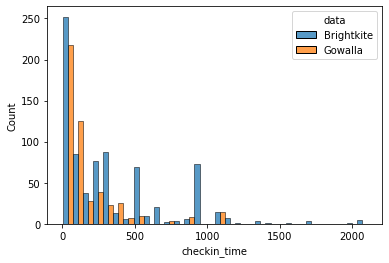

In [21]:
#sns.histplot(data = bk_gw_friends, x = 'checkin_time', hue = 'data', multiple="dodge", bins = 30);
sns.histplot(data = bk_gw_friends, x = 'checkin_time', hue = 'data',  multiple="dodge", bins = 30);

In [22]:
# Intermediately save the dataframes
#bk_checkins_merged.to_pickle("B_checkins_merged.pickle")
#gw_checkins_merged.to_pickle("G_checkins_merged.pickle")
#bk_checkins.to_pickle("B_checkins_MS4.pickle")
#gw_checkins.to_pickle("G_checkins_MS4.pickle")

### Does it depend on whether they live in a city or not?

In [23]:
B_homes = B_homes[B_homes.index.isin(bk_checkins['user_id'])]#.isin()
G_homes = G_homes[G_homes.index.isin(gw_checkins['user_id'])]#.isin()

In [24]:
# Does user live in a city?
B_merge = B_homes.merge(cities, left_on = 'country', right_on = 'iso2')
B_merge['distance_to_city'] = B_merge.apply(lambda row: distance((row['latitude'], row['longitude']), (row['lat'],row['lng']) ).km, axis = 1)
B_lives_urban = B_merge.groupby("user").apply(lambda x: (x['distance_to_city'] < x['radius']).any()).to_frame()
B_lives_urban = B_lives_urban.rename(columns = {0:'lives_urban'})
B_homes = B_homes.merge(B_lives_urban, left_on = 'user', right_index = True)

In [25]:
# Does user live in a city?
G_merge = G_homes.merge(cities, left_on = 'country', right_on = 'iso2')
G_merge['distance_to_city'] = G_merge.apply(lambda row: distance((row['latitude'], row['longitude']), (row['lat'],row['lng']) ).km, axis = 1)
G_lives_urban = G_merge.groupby("user").apply(lambda x: (x['distance_to_city'] < x['radius']).any()).to_frame()
G_lives_urban = G_lives_urban.rename(columns = {0:'lives_urban'})
G_homes = G_homes.merge(G_lives_urban, left_on = 'user', right_index = True)

In [26]:
# merge homes and check_ins
bk_friend_city = bk_friend_visited.merge(B_homes, left_index = True, right_index = True)
gw_friend_city = gw_friend_visited.merge(G_homes, left_index = True, right_index = True)
bk_gw_friend_city = bk_friend_city.append(gw_friend_city)
bk_gw_friend_city.head(3)

checkin_time        data   longitude   latitude country  user  \
user_id to_id                                                                  
1       3              1110  Brightkite -122.353819  37.581821      US     1   
        5              1112  Brightkite -122.353819  37.581821      US     1   
        7              1121  Brightkite -122.353819  37.581821      US     1   

               lives_urban  
user_id to_id               
1       3            False  
        5            False  
        7            False

In [27]:
#sns.histplot(data = bk_gw_friend_city, x = 'checkin_time', hue = 'lives_urban', bins = 30);

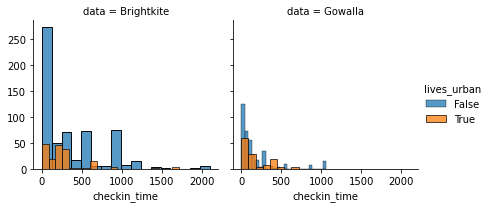

In [28]:
g = sns.FacetGrid(bk_gw_friend_city, col="data", hue = 'lives_urban')
g.map(sns.histplot, 'checkin_time') #,  multiple="dodge"
g.add_legend();

In [32]:
bk_gw_friend_city['lives_urban'].count()

1282

### Does it depend on the season of the year?

In [30]:
# transform date to datetime
# only take us samples, so seasons don't get confused
# create a variable 'season', do the same plot as before